## ✍️ Stage 5: Sequence Models and Natural Language Processing (NLP)

### Topics:
- Recurrent Neural Networks (RNNs)
- Encoder-decoder architectures
- LSTMs, Seq2Seq
- Attention Mechanisms and Multi-Head Attention.
- Transformers: Architecture, BERT, GPT.

## 🔁 Recurrent Neural Networks (RNNs)

Recurrent Neural Networks are designed to work with **sequential data** such as text, time series, or speech. Unlike traditional neural networks that treat each input independently, RNNs maintain a **memory** of past inputs through a hidden state that gets updated over time.

---

### 🧠 **Intuitive Explanation**

Imagine you're reading a sentence word by word. Your understanding of each new word depends on the words you've already read. RNNs work the same way — they **process one input at a time**, updating an internal state to "remember" past information.

---

### ⚙️ **Technical Explanation**

At each time step $t$, an RNN takes:
- an input vector $x_t$
- the previous hidden state $h_{t-1}$

It computes the new hidden state as:

$$
h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

And optionally, the output:

$$
y_t = W_{hy} h_t + b_y
$$

Where:
- $W_{xh}$ is the input-to-hidden weights
- $W_{hh}$ is the hidden-to-hidden (recurrent) weights
- $W_{hy}$ is the hidden-to-output weights
- $b_h$, $b_y$ are bias terms
- $\tanh$ is the activation function (other options like ReLU are also used)

---

### 💡 **Core Ideas**

- **Weight Sharing**: The same weights are used at each time step.
- **Memory**: The hidden state $h_t$ summarizes information from all previous inputs $(x_1, x_2, ..., x_t)$.
- **Backpropagation Through Time (BPTT)** is used to train the model by unrolling it over time steps.

---

### ⚠️ **Challenges**

- 🔽 **Vanishing Gradients**: Difficult to learn long-range dependencies.
- 🔼 **Exploding Gradients**: Can lead to unstable training.

---

### 📌 **When to Use RNNs**

Use RNNs when:
- The **order** of inputs matters (e.g., sentences, time series).
- You need to model **temporal dependencies** or **context**.

---


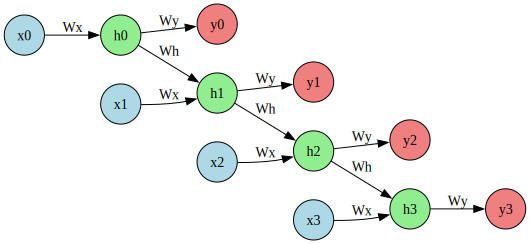

In [3]:
from graphviz import Digraph

def draw_rnn_unrolled(time_steps=3):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR')  # Left to right

    # Add nodes for hidden states and inputs
    for t in range(time_steps):
        dot.node(f"x{t}", f"x{t}", shape="circle", style="filled", fillcolor="lightblue")
        dot.node(f"h{t}", f"h{t}", shape="circle", style="filled", fillcolor="lightgreen")

    # Add edges for input to hidden connections
    for t in range(time_steps):
        dot.edge(f"x{t}", f"h{t}", label="Wx")

    # Add recurrent connections
    for t in range(1, time_steps):
        dot.edge(f"h{t-1}", f"h{t}", label="Wh")

    # Add output nodes (optional)
    for t in range(time_steps):
        dot.node(f"y{t}", f"y{t}", shape="circle", style="filled", fillcolor="lightcoral")
        dot.edge(f"h{t}", f"y{t}", label="Wy")

    return dot

# Display the graph
draw_rnn_unrolled(time_steps=4)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Set seed for reproducibility
torch.manual_seed(0)

# Dummy data: sequence of numbers from 0 to 1000 → learn to predict the next number
sequence = np.array([i for i in range(100)], dtype=np.float32)

# Prepare sequences: input (x) and target (y)
def create_dataset(seq, input_size):
    x = []
    y = []
    for i in range(len(seq) - input_size):
        x.append(seq[i:i+input_size])
        y.append(seq[i+input_size])
    return np.array(x), np.array(y)

input_size = 3  # how many steps to look back
x, y = create_dataset(sequence, input_size)

# Convert to tensors
x_tensor = torch.tensor(x).unsqueeze(-1)  # shape (batch, seq_len, 1)
y_tensor = torch.tensor(y).unsqueeze(-1)  # shape (batch, 1)

# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        last_out = out[:, -1, :]  # take last hidden state
        return self.fc(last_out)

# Hyperparameters
input_dim = 1 #Number of features
hidden_dim = 10 #number of "neurons"
output_dim = 1
lr = 0.01
epochs = 300

# Initialize model, loss, and optimizer
model = SimpleRNN(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Test prediction
model.eval()
test_input = torch.tensor([[10, 11, 12]], dtype=torch.float32).unsqueeze(-1)  # (1, 3, 1)
pred = model(test_input).item()
print(f"\nPrediction for input [10, 11, 12]: {pred:.2f}")


Epoch 50, Loss: 2825.6826
Epoch 100, Loss: 2380.5339
Epoch 150, Loss: 2006.9341
Epoch 200, Loss: 1693.4469
Epoch 250, Loss: 1430.2433
Epoch 300, Loss: 1209.1809

Prediction for input [10, 11, 12]: 13.01


## 🏗️ General Encoder-Decoder Framework

- The **encoder** compresses the input (which could be a sequence, an image, etc.) into a **context vector** (or set of vectors).
- The **decoder** uses this context to **generate the output**.

The **types of encoders and decoders** can vary depending on the task:

### 🔶 Types of Encoder-Decoder Models

| Type                    | Encoder                  | Decoder                         | Example Task                                    |
|-------------------------|--------------------------|----------------------------------|-------------------------------------------------|
| **RNN-based**           | RNN/LSTM/GRU             | RNN/LSTM/GRU                    | Machine translation, text summarization         |
| **CNN-based**           | CNN (Convolutional)      | Deconvolutional CNN (transposed conv) | Image segmentation, super-resolution   |
| **ANN (Feedforward)**   | Fully connected layers   | Fully connected layers          | Autoencoders for dimensionality reduction       |
| **Transformer-based**   | Self-attention layers    | Self-attention layers           | Text translation, summarization                |
| **Variational Autoencoders (VAE)** | ANN/Conv + stochastic sampling | ANN/Conv        | Generative modeling                        |

---

## 🏙️ Encoder-Decoder with ANNs

In fact, **autoencoders** are a classic example of an encoder-decoder using **only feedforward layers (ANNs)**.

- 🔹 **Encoder:** Compresses the input into a latent code (vector).
- 🔹 **Decoder:** Reconstructs the input from the latent code.

Example:
- Input: `[x1, x2, x3]`
- Encoder: Dense layers → latent representation (e.g., `[z1, z2]`)
- Decoder: Dense layers → reconstructed `[x1', x2', x3']`

---

## 🤔 So why are RNNs often used?

- For **sequence data**, RNNs (or their modern replacements like **Transformers**) naturally handle variable-length input.
- **ANNs** (feedforward networks) are **fixed-size** input-output models, so they’re great for autoencoders and other fixed-dimension tasks (e.g., image compression) but less ideal for sequences.

---

# 🧠 What is an LSTM?

**LSTM** stands for **Long Short-Term Memory**, and it’s a special type of **Recurrent Neural Network (RNN)**.  
It was designed to solve the **vanishing gradient problem** that standard RNNs face when learning long-term dependencies.

- **RNNs** process data **step-by-step** in a sequence, passing information (hidden state) from one time step to the next.
- However, standard RNNs struggle to remember information over long sequences because the gradients used for learning tend to either **vanish** (become too small) or **explode** (become too large).

LSTMs fix this by using a **memory cell** and **gates** to control the flow of information.

---

## 🏗️ LSTM Cell Structure

An **LSTM cell** contains:
- **Cell state ($C$)**: The memory of the cell.
- **Hidden state ($h$)**: The output at the current time step.
- **Input ($x_t$)**: The input at time step $t$.

It also has **3 gates**:
1️⃣ **Forget Gate**: Decides what information to forget from the cell state.  
2️⃣ **Input Gate**: Decides what new information to add to the cell state.  
3️⃣ **Output Gate**: Decides what part of the cell state to output.

---

## 🔢 Basic Equations

At time step $t$:

- **Forget gate:**  
$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$

- **Input gate:**  
$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$

- **Candidate cell state:**  
$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$

- **Cell state update:**  
$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$

- **Output gate:**  
$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$

- **Hidden state:**  
$h_t = o_t * \tanh(C_t)$

---

## 🌊 What Does It All Mean?

✅ **Forget gate**: Keeps or discards old memory.  
✅ **Input gate**: Adds new memory.  
✅ **Output gate**: Determines what to output.

This allows LSTMs to **"remember" important information for long sequences** and **forget unimportant parts**.

---

## 🤔 Why LSTMs are Powerful

- RNNs can forget long-term dependencies.  
- LSTMs **solve this**, making them great for tasks like:
  - Language modeling
  - Text generation
  - Time-series prediction
  - Speech recognition

---

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Set seed for reproducibility
torch.manual_seed(0)

# Dummy data: sequence of numbers from 0 to 1000 → learn to predict the next number
sequence = np.array([i for i in range(100)], dtype=np.float32)

# Prepare sequences: input (x) and target (y)
def create_dataset(seq, input_size):
    x = []
    y = []
    for i in range(len(seq) - input_size):
        x.append(seq[i:i+input_size])
        y.append(seq[i+input_size])
    return np.array(x), np.array(y)

input_size = 3  # how many steps to look back
x, y = create_dataset(sequence, input_size)

# Convert to tensors
x_tensor = torch.tensor(x).unsqueeze(-1)  # shape (batch, seq_len, 1)
y_tensor = torch.tensor(y).unsqueeze(-1)  # shape (batch, 1)

# Define the RNN model
class LSTMS(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMS, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # hn: (num_layers, batch, hidden_dim)
        out = self.fc(hn[-1])      # Take last layer's hidden state
        return out



# Hyperparameters
input_dim = 1 #Number of features
hidden_dim = 10 #number of "neurons"
output_dim = 1
lr = 0.01
epochs = 300

# Initialize model, loss, and optimizer
model = LSTMS(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Test prediction
model.eval()
test_input = torch.tensor([[10, 11, 12]], dtype=torch.float32).unsqueeze(-1)  # (1, 3, 1)
pred = model(test_input).item()
print(f"\nPrediction for input [10, 11, 12]: {pred:.2f}")



Epoch 50, Loss: 2783.0605
Epoch 100, Loss: 2321.4629
Epoch 150, Loss: 1947.4984
Epoch 200, Loss: 1578.0094
Epoch 250, Loss: 1302.0115
Epoch 300, Loss: 1082.3044

Prediction for input [10, 11, 12]: 13.14


# 🔥 Seq2Seq (Sequence-to-Sequence) Models 🔥

A **Seq2Seq** model is a **neural architecture** used to **map an input sequence to an output sequence**. It consists of:

- 🏗️ **Encoder**: Transforms the input sequence into a **fixed-size latent vector (context)**.  
- 🏗️ **Decoder**: Uses the context to generate the output sequence **step by step**.  


---

## 🚀 Mathematical Formulation

Given input sequence **$X = (x_1, x_2, \dots, x_T)$** and output sequence **$Y = (y_1, y_2, \dots, y_{T'})$**:  

- The **encoder** computes hidden states **$h_t$**:  
$$ h_t = f_{\text{enc}}(x_t, h_{t-1}) $$
- The **context vector** $c$ summarizes the sequence:  
$$ c = h_T $$
- The **decoder** generates each output token conditioned on $c$ and past outputs:  
$$ s_t = f_{\text{dec}}(y_{t-1}, s_{t-1}, c) $$
$$ \hat{y}_t = g(s_t) $$

---

## 📈 Use Cases
- 🗣️ **Machine translation** (e.g., English → Spanish)  
- 📝 **Text summarization**  
- 🤖 **Chatbots and dialogue generation**  
- 📉 **Time series forecasting** (encoder-decoder for multistep prediction)  

---

## 🕸️ Key Concepts
- 🔒 **Fixed-length bottleneck**: Vanilla Seq2Seq compresses the input into a single vector $c$ (limitation for long sequences).  



In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from random import randint

# 📌 Hyperparameters
INPUT_DIM = 12   # 0-9 digits + SOS + EOS
OUTPUT_DIM = 12
HID_DIM = 64
N_EPOCHS = 20
BATCH_SIZE = 64   # Bigger batch
LEARNING_RATE = 0.001
MAX_LEN = 7

PAD, SOS, EOS = 0, 10, 11

# 📚 Encoder with LSTM
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, hid_dim)
        self.lstm = nn.LSTM(hid_dim, hid_dim)
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

# 📚 Decoder with LSTM
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, hid_dim)
        self.lstm = nn.LSTM(hid_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).unsqueeze(0)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

# 🔥 Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_sixze = trg.shape[1]
        trg_len = trg.shape[0]
        output_dim = self.decoder.fc_out.out_features
        
        outputs = torch.zeros(trg_len, batch_size, output_dim)
        hidden, cell = self.encoder(src)
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if torch.rand(1).item() < teacher_forcing_ratio else top1
        return outputs

# ⚙️ Initialize Model
encoder = Encoder(INPUT_DIM, HID_DIM)
decoder = Decoder(OUTPUT_DIM, HID_DIM)
model = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD)

# 🏗️ Bigger Synthetic Dataset
def generate_example():
    length = randint(3, MAX_LEN)
    src_seq = [randint(1,9) for _ in range(length)]
    trg_seq = src_seq[::-1]  # Reverse as target
    src = [SOS] + src_seq + [EOS] + [PAD]*(MAX_LEN+2-len(src_seq)-2)
    trg = [SOS] + trg_seq + [EOS] + [PAD]*(MAX_LEN+2-len(trg_seq)-2)
    return torch.tensor(src), torch.tensor(trg)

def generate_batch(batch_size):
    src_batch, trg_batch = [], []
    for _ in range(batch_size):
        src, trg = generate_example()
        src_batch.append(src.unsqueeze(1))
        trg_batch.append(trg.unsqueeze(1))
    src = torch.cat(src_batch, dim=1)
    trg = torch.cat(trg_batch, dim=1)
    return src, trg

# 🔥 Training Loop
for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = 0
    for _ in range(200):  # More batches per epoch
        src, trg = generate_batch(BATCH_SIZE)
        optimizer.zero_grad()
        output = model(src, trg)
        
        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        trg_gold = trg[1:].reshape(-1)
        
        loss = criterion(output, trg_gold)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/200:.4f}')


Epoch 1, Loss: 1.5810
Epoch 2, Loss: 0.8332
Epoch 3, Loss: 0.3937
Epoch 4, Loss: 0.2235
Epoch 5, Loss: 0.1468
Epoch 6, Loss: 0.1018
Epoch 7, Loss: 0.0732
Epoch 8, Loss: 0.0573
Epoch 9, Loss: 0.0431
Epoch 10, Loss: 0.0311
Epoch 11, Loss: 0.0279
Epoch 12, Loss: 0.0220
Epoch 13, Loss: 0.0173
Epoch 14, Loss: 0.0196
Epoch 15, Loss: 0.0135
Epoch 16, Loss: 0.0142
Epoch 17, Loss: 0.0088
Epoch 18, Loss: 0.0128
Epoch 19, Loss: 0.0090
Epoch 20, Loss: 0.0073


# 🔍 Understanding the Attention Mechanism

The **attention mechanism** is a powerful concept in deep learning, especially in models that process sequences, like in **natural language processing (NLP)** and **time series forecasting**.

---

## 🎯 Core Idea

Traditional models like RNNs or LSTMs compress an entire input sequence into a single vector, which can make it difficult to retain information from earlier steps in long sequences.

**Attention** allows the model to **focus on the most relevant parts of the input** when producing each output. Rather than treating all input positions equally, attention **assigns a weight** to each input element based on its relevance to the current output step.

---

## 🧠 Why It’s Useful

- It reduces the burden of remembering long sequences.
- It dynamically identifies which parts of the input are most useful at each output step.
- It enables parallel processing (in Transformers) and improves performance on tasks like translation, summarization, and question answering.

---

## ⚙️ How Attention Works

Let’s define:

- **Query (Q)**: the decoder hidden state at the current time step (a vector)
- **Key (K)**: the encoder hidden states for each time step in the input sequence (vectors)
- **Value (V)**: the same as Keys, used to compute the final output.

### Steps:

1. **Calculate raw attention scores**:

$$
\text{score}(Q, K) = Q \cdot K^T
$$

2. **Normalize the scores using softmax** to get attention weights:

$$
\alpha_i = \frac{e^{\text{score}_i}}{\sum_j e^{\text{score}_j}}
$$

3. **Use the weights to compute a weighted average of the values**:

$$
\text{Attention}(Q, K, V) = \sum_i \alpha_i \cdot V_i
$$

This gives a **context vector** summarizing the relevant parts of the input for the current step.

---

## 📚 Analogy

Imagine writing a summary of a book. For each sentence you write, you might go back and re-read parts of the book. You don’t re-read everything—you **focus on the important parts**. That’s attention!

---



## 🔍 Comparison of Context Vectors in Sequence Models

| **Model**              | **Context Vector** Description                                                                 | **Static/Dynamic** | **How It's Computed**                                                                                         | **Strengths**                                              | **Limitations**                                                |
|------------------------|-----------------------------------------------------------------------------------------------|---------------------|----------------------------------------------------------------------------------------------------------------|------------------------------------------------------------|----------------------------------------------------------------|
| **Vanilla RNN**        | Last hidden state of the encoder: $$ h_T $$                                                  | Static              | $$ h_t = \tanh(W_h h_{t-1} + W_x x_t + b) $$                             | Simple implementation                                       | Struggles with long-term dependencies (vanishing gradients)     |
| **LSTM**               | Last hidden state of the encoder: $$ h_T $$                                                  | Static              | Uses gates: $$ h_t = o_t \odot \tanh(c_t) $$, with memory cell $$ c_t $$ updated via input/forget gates       | Remembers longer sequences than RNN                        | Still compresses full sequence into one vector                  |
| **Seq2Seq (RNN/LSTM)** | Uses encoder’s final hidden state as a context vector                                         | Static              | Same as above (RNN or LSTM depending on encoder architecture)                                                 | Effective for short sequences                              | Information loss for long sequences                             |
| **With Attention**     | Weighted sum of all encoder hidden states: $$ c_t = \sum_{i=1}^{T} \alpha_{t,i} \cdot h_i $$ | **Dynamic**         | Attention weights $$ \alpha_{t,i} $$ are computed via score function (e.g., dot, additive, etc.)             | Allows decoder to focus on different parts of the input    | More computationally expensive, but powerful                    |

---


### 💡 Key Takeaway

- **Without attention**, the model summarizes the entire sequence in the last hidden state: a bottleneck for long sequences.
- **With attention**, the model uses **all** hidden states, reweighted per decoding step, enabling more **flexible and accurate decoding**.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Load dataset (subset for speed)
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers','footers','quotes'))

# Simple tokenizer & vocabulary using CountVectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X_counts = vectorizer.fit_transform(newsgroups.data)

# Convert to dense and truncate/pad sequences to fixed length (e.g., 100 words)
X = X_counts.toarray()
max_len = 100
X = np.array([np.pad(x[:max_len], (0, max_len - len(x[:max_len])), 'constant') for x in X])

# Encode labels
le = LabelEncoder()
y = le.fit_transform(newsgroups.target)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset wrapper
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = NewsDataset(X_train, y_train)
test_ds = NewsDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# Define simple RNN with Attention
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
    def forward(self, encoder_outputs):
        # encoder_outputs: (batch_size, seq_len, hidden_dim)
        weights = torch.softmax(self.attn(encoder_outputs).squeeze(-1), dim=1)  # (batch_size, seq_len)
        weighted = torch.bmm(weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, hidden_dim)
        return weighted, weights

class RNNWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, x):
        emb = self.embedding(x)
        outputs, _ = self.rnn(emb)
        attn_output, attn_weights = self.attention(outputs)
        logits = self.fc(attn_output)
        return logits, attn_weights

# Instantiate model
vocab_size = 1000
embed_dim = 64
hidden_dim = 128
output_dim = len(categories)

model = RNNWithAttention(vocab_size, embed_dim, hidden_dim, output_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (just a few epochs for demo)
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        logits, attn = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {total_loss / len(train_loader):.4f}")

# Quick evaluation on test set accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        logits, _ = model(batch_x)
        preds = logits.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
print(f"Test accuracy: {correct / total:.4f}")


Epoch 1 loss: 1.3734
Epoch 2 loss: 1.3705
Epoch 3 loss: 1.3689
Epoch 4 loss: 1.3691
Epoch 5 loss: 1.3679
Epoch 6 loss: 1.3646
Epoch 7 loss: 1.3575
Epoch 8 loss: 1.3573
Epoch 9 loss: 1.3543
Epoch 10 loss: 1.3532
Test accuracy: 0.2935


## 🔍 Multi-Head Attention 

Multi-Head Attention allows the model to jointly attend to information from different representation subspaces at different positions. Instead of performing a single attention function, it runs multiple attention mechanisms ("heads") in parallel.

🧠 Analogy
- Think of multi-head attention like having a committee of experts:

- Each expert (head) looks at the same document (input),

- But each uses a different lens or perspective (different projection),

- Then their opinions are combined (concatenated) and merged (via $W^O$) into a final decision.

### 1. Inputs

Let:

- $Q \in \mathbb{R}^{T_q \times d_{\text{model}}}$: Query matrix (e.g., decoder hidden states or input embeddings)  
- $K \in \mathbb{R}^{T_k \times d_{\text{model}}}$: Key matrix (e.g., encoder hidden states or input embeddings)  
- $V \in \mathbb{R}^{T_v \times d_{\text{model}}}$: Value matrix (typically same shape as $K$)  

where $T_q$, $T_k$, and $T_v$ are the sequence lengths for the query, key, and value, and $d_{\text{model}}$ is the model dimension.

### 2. Linear Projections for Each Head

For each of the $h$ attention heads, we project $Q$, $K$, and $V$ using different learned linear transformations:

$$
Q_i = Q W_i^Q,\quad K_i = K W_i^K,\quad V_i = V W_i^V
$$

where:

- $W_i^Q, W_i^K, W_i^V \in \mathbb{R}^{d_{\text{model}} \times d_k}$  
- Typically, $d_k = d_v = d_{\text{model}} / h$

### 3. Scaled Dot-Product Attention (per head)

Each head computes attention as:

$$
\text{head}_i = \text{Attention}(Q_i, K_i, V_i) = \text{softmax}\left( \frac{Q_i K_i^\top}{\sqrt{d_k}} \right) V_i
$$

This results in a matrix of shape $(T_q \times d_v)$ for each head.

### 4. Concatenate and Final Linear Projection

After computing all $h$ heads, we concatenate them along the feature dimension and apply a final linear projection:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O
$$

where $W^O \in \mathbb{R}^{h d_v \times d_{\text{model}}}$ is a learned output projection matrix.

### 5. Shape Summary

Assuming:

- $d_{\text{model}} = 512$  
- $h = 8$ (so $d_k = d_v = 64$)

Then:

- Each head output: $(T_q \times d_k)$  
- Concatenated heads: $(T_q \times (h \cdot d_v)) = (T_q \times 512)$  
- Final output: $(T_q \times d_{\text{model}})$ after applying $W^O$

---

This formulation enables the model to learn attention patterns from multiple perspectives simultaneously, improving its ability to model complex dependencies.




| Feature                          | Single-Head Attention                            | Multi-Head Attention                                           |
|----------------------------------|--------------------------------------------------|----------------------------------------------------------------|
| **Definition**                   | One attention mechanism                         | Multiple attention mechanisms in parallel                     |
| **Number of Context Vectors**    | One per query                                   | One per head, then concatenated into one                      |
| **Computation**                  | Uses single Q, K, V projections                 | Splits Q, K, V into `h` parts, each processed independently   |
| **Projection Dimensions**        | Q, K, V: $\mathbb{R}^{d_{\text{model}}}$        | Q, K, V: $\mathbb{R}^{d_k = d_{\text{model}}/h}$ per head     |
| **Attention Diversity**          | Limited to one representation                   | Can attend to information from different representation subspaces |
| **Output Shape**                 | $\mathbb{R}^{T_q \times d_{\text{model}}}$      | $\mathbb{R}^{T_q \times d_{\text{model}}}$ (after concat + projection) |
| **Learned Parameters**           | One set of $W^Q$, $W^K$, $W^V$, $W^O$            | One set per head: $W_i^Q$, $W_i^K$, $W_i^V$, shared $W^O$     |
| **Expressive Power**            | Lower                                            | Higher, captures multiple relationships                       |
| **Used in Transformer?**         | No                                              | Yes (standard in Transformers)                                |


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 1. Load dataset (subset for speed)
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# 2. Vectorize text using CountVectorizer
vectorizer = CountVectorizer(max_features=10000, stop_words='english')
X_counts = vectorizer.fit_transform(newsgroups.data)

# 3. Convert to dense array and pad/truncate to fixed length
X = X_counts.toarray()
max_len = 100
X = np.array([np.pad(x[:max_len], (0, max_len - len(x[:max_len])), 'constant') for x in X])

# 4. Encode labels
le = LabelEncoder()
y = le.fit_transform(newsgroups.target)

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Dataset wrapper
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = NewsDataset(X_train, y_train)
test_ds = NewsDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# 7. Define model with RNN + Multihead Attention
class RNNWithMultiheadAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_heads=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim*2, num_heads=num_heads, batch_first=False)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        emb = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        rnn_out, _ = self.rnn(emb)  # (batch_size, seq_len, hidden_dim*2)
        rnn_out = rnn_out.transpose(0, 1)  # (seq_len, batch_size, hidden_dim*2)
        attn_output, _ = self.attn(rnn_out, rnn_out, rnn_out)  # self-attention
        attn_output_mean = attn_output.mean(dim=0)  # (batch_size, hidden_dim*2)
        logits = self.fc(attn_output_mean)  # (batch_size, output_dim)
        return logits, None

# 8. Instantiate model
vocab_size = 1000
embed_dim = 64
hidden_dim = 128
output_dim = len(categories)
model = RNNWithMultiheadAttention(vocab_size, embed_dim, hidden_dim, output_dim, num_heads=4)

# 9. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 10. Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        logits, _ = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {total_loss / len(train_loader):.4f}")

# 11. Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        logits, _ = model(batch_x)
        preds = logits.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
print(f"Test accuracy: {correct / total:.4f}")


Epoch 1 loss: 1.3704
Epoch 2 loss: 1.3652
Epoch 3 loss: 1.3617
Epoch 4 loss: 1.3655
Epoch 5 loss: 1.3594
Epoch 6 loss: 1.3579
Epoch 7 loss: 1.3628
Epoch 8 loss: 1.3587
Epoch 9 loss: 1.3580
Epoch 10 loss: 1.3564
Test accuracy: 0.2965


# 🤖 What Are Transformers?

Transformers are a **type of deep learning model architecture** that has revolutionized **natural language processing (NLP)** and is now used in **vision**, **speech**, and **time series forecasting**.

---

## 🔧 What Is a Transformer?

The **Transformer** was introduced in the paper [“Attention Is All You Need” (Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762). Unlike previous sequence models like RNNs or LSTMs, Transformers **do not process data sequentially**. Instead, they operate **in parallel** using a mechanism called **self-attention**.



---

## 🚀 Key Concepts

| Component              | Description |
|------------------------|-------------|
| **Self-Attention**     | Lets each word "attend" to others to understand context. Example: In “She fed her dog because it was hungry,” the word “it” refers to “dog.” |
| **Positional Encoding**| Adds order information since Transformers process all words at once. |
| **Multi-Head Attention**| Uses multiple attention mechanisms in parallel to learn different relationships between words. |
| **Feedforward Layers** | Standard fully connected (dense) layers applied after attention. |
| **Layer Norm & Residuals** | Help stabilize training and keep gradient flow healthy. |

---

## 🔄 Transformer vs RNN

| Feature             | RNN/LSTM                | Transformer              |
|---------------------|-------------------------|--------------------------|
| **Sequential**      | Yes                     | No (parallelized)        |
| **Long-range context**| Hard to learn          | Easy with attention      |
| **Training Speed**  | Slower                  | Faster                   |
| **Performance (NLP)**| Good                   | State-of-the-art         |

---

# 🧠 Self-Attention Mechanism (Transformers)

## 🔍 Purpose

Self-attention allows each token in a sequence to **attend to all other tokens**, capturing contextual dependencies regardless of their position. This is especially powerful in language tasks.

---

## 🧱 Core Components

Given a sequence of token embeddings $X \in \mathbb{R}^{n \times d}$:

- $n$: Sequence length  
- $d$: Embedding dimension  

We compute:

- **Query** matrix: $Q = XW^Q$  
- **Key** matrix: $K = XW^K$  
- **Value** matrix: $V = XW^V$  

Where:
- $W^Q, W^K, W^V \in \mathbb{R}^{d \times d_k}$ are learnable weight matrices  
- $d_k$: Dimension of queries and keys (often $d_k = d / h$ if using multi-head attention)

---

## 📐 Scaled Dot-Product Attention

$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^\top}{\sqrt{d_k}} \right)V
$$

**Explanation**:

1. **Similarity**: Compute $QK^\top$, the dot product between queries and keys.
2. **Scaling**: Divide by $\sqrt{d_k}$ to stabilize gradients.
3. **Softmax**: Converts scores to probabilities.
4. **Weighting**: Applies those probabilities to the value vectors $V$.

The result is a **contextualized representation** of the input sequence.

---

## ⚙️ What Happens for a Token $x_i$

1. Create query vector $q_i$ from $x_i$
2. Compare $q_i$ with all key vectors $k_j$
3. Compute attention weights via softmax
4. Use weights to combine value vectors $v_j$
5. Output is a context-aware vector for token $x_i$

---

## 🎯 Why Is This Important?

- **Parallelizable**: Unlike RNNs/LSTMs, the whole sequence is processed at once.
- **Global context**: Each token attends to every other token.
- **Dynamic**: Attention changes based on input, allowing flexible modeling.

---

## 📌 In Transformers

Self-attention is a core operation used repeatedly in the Transformer architecture — in both the encoder and decoder. It's often used in **Multi-Head Attention**, where several self-attention heads run in parallel to learn richer relationships.




| Feature                     | Attention                                         | Self-Attention                                         |
|----------------------------|--------------------------------------------------|--------------------------------------------------------|
| **Definition**             | A mechanism that lets the model focus on relevant parts of a **different sequence**. | A mechanism that lets each element of a sequence attend to **other elements within the same sequence**. |
| **Typical Use Case**       | Decoder attends to encoder output (e.g., translation). | Encoder or decoder attends to its own inputs (e.g., understanding sentence structure). |
| **Input Source**           | Query (Q), Key (K), and Value (V) from **different sequences**. | Query (Q), Key (K), and Value (V) from **the same sequence**. |
| **Formula**                | $Attention(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V$ | Same formula, but $Q = K = V$ from the same sequence. |
| **Model Type Examples**    | Seq2Seq with attention, Encoder-Decoder models.   | Transformers, BERT, GPT, etc.                          |
| **Purpose**                | Helps decoder know which encoder outputs to focus on. | Helps the model understand relationships within a single input (e.g., long-distance dependencies in a sentence). |


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Transformer-based classifier
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, max_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, embed_dim))
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=2)
        
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len)
        emb = self.embedding(x) + self.pos_embedding[:, :x.size(1), :]  # (batch, seq, embed)
        enc_output = self.transformer_encoder(emb)  # (batch, seq, embed)
        pooled = enc_output.mean(dim=1)  # global average pooling
        return self.classifier(pooled)

# Parameters
vocab_size = 10000
embed_dim = 128
num_heads = 4
num_classes = len(np.unique(y))
max_len = 100

model = TransformerClassifier(vocab_size, embed_dim, num_heads, num_classes, max_len)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(30):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        logits = model(batch_x)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
print(f"Test accuracy: {correct / total:.4f}")



Epoch 1, Loss: 1.4609
Epoch 2, Loss: 1.3851
Epoch 3, Loss: 1.3848
Epoch 4, Loss: 1.3693
Epoch 5, Loss: 1.3750
Epoch 6, Loss: 1.3686
Epoch 7, Loss: 1.3564
Epoch 8, Loss: 1.3552
Epoch 9, Loss: 1.3464
Epoch 10, Loss: 1.3418
Epoch 11, Loss: 1.3419
Epoch 12, Loss: 1.3284
Epoch 13, Loss: 1.3265
Epoch 14, Loss: 1.3181
Epoch 15, Loss: 1.3179
Epoch 16, Loss: 1.3146
Epoch 17, Loss: 1.3141
Epoch 18, Loss: 1.3038
Epoch 19, Loss: 1.3008
Epoch 20, Loss: 1.3101
Epoch 21, Loss: 1.3018
Epoch 22, Loss: 1.3001
Epoch 23, Loss: 1.2988
Epoch 24, Loss: 1.2989
Epoch 25, Loss: 1.2967
Epoch 26, Loss: 1.2950
Epoch 27, Loss: 1.2979
Epoch 28, Loss: 1.2931
Epoch 29, Loss: 1.2948
Epoch 30, Loss: 1.2943
Test accuracy: 0.3083
